#CafChem tools for creating a Multi-Layer Perceptron with Pytorch and fitting to chemical data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/MLP_with_PyTorch_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file.
- featurize data, remove NaNs, perform scaling. Split data into training and validation sets.
- Create an MLP with a user defined number of hidden layers.
- visualize predicted data.

## Requirements:
- This notebook will install deepchem and mordred
- It will pull the CafChem tools from Github.
- It will install all needed libraries.

## Set-up

### Install libraries

In [1]:
!pip install deepchem
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.1 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=1db669b68f1f752d0841f876b900a82f3dd8fff62719f5041449e6becdd4f335
  Stored in directory: /root/.cache/pip/wheels/e8/79/b8/f4f1dfbb736c2b8605cf5068cd633f4d2869defb89908aef93
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successful

### Pull CafChem from Github and import libraries

In [5]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.7 MB/s eta 0:00:00


In [71]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 814 (delta 180), reused 54 (delta 54), pack-reused 571 (from 2)
Receiving objects: 100% (814/814), 43.03 MiB | 28.22 MiB/s, done.
Resolving deltas: 100% (468/468), done.


In [2]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import CafChem.CafChemMLPPyTorch as ccmlp

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Read in data and featurize
- Can choose RDKit descriptors, Mordred descriptors, or fingerprints

In [3]:
df = pd.read_csv('/content/905-unique-statins.csv')
df.head()

,Unnamed: 0,Ligand SMILES,IC50 (nM)
0,7,[Na+].CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])...,0.106
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300


In [85]:
X, y, smiles = ccmlp.featurize(df['Ligand SMILES'], df['IC50 (nM)'])

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


### Use if target data should be transformed with a log function

In [86]:
trans_y = []
for i, val in enumerate(y):
  try:
    newval = np.log10(val)
    trans_y.append(newval)
  except:
    print(f"Could not transform {i}")

In [87]:
y = trans_y

## Prepare data
- scale features
- split into training and validation data
- create Torch datasets and dataloaders

In [88]:
statins = ccmlp.prep_data(128)
X_train, X_test, y_train, y_test, scaler = statins.scale_split(X, y, test_size=0.2, random_state=32)

prep data class initialized!


In [89]:
train_dataset, test_dataset, train_loader, test_loader = statins.create_data_loader()

## Create and train model
- setup loss function and optimizer
- create model with user defined numbers of neurons per layer, number of hidden layers
- train model

In [90]:
loss_function = nn.MSELoss()
model = ccmlp.MLP_Model(neurons=400, input_dims=len(X_train[0]), num_hidden_layers=6)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [91]:
epochs = 60
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  model = ccmlp.train(train_loader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
Batch: 0, Loss: 7.1598096 [    0/  724]
Batch: 2, Loss: 7.7720242 [  256/  724]
Batch: 4, Loss: 7.2481818 [  512/  724]
Epoch 2
-------------------------------
Batch: 0, Loss: 2.0424623 [    0/  724]
Batch: 2, Loss: 3.7885571 [  256/  724]
Batch: 4, Loss: 3.3218338 [  512/  724]
Epoch 3
-------------------------------
Batch: 0, Loss: 4.4758482 [    0/  724]
Batch: 2, Loss: 3.6565835 [  256/  724]
Batch: 4, Loss: 2.9821405 [  512/  724]
Epoch 4
-------------------------------
Batch: 0, Loss: 2.0979486 [    0/  724]
Batch: 2, Loss: 1.7317084 [  256/  724]
Batch: 4, Loss: 1.5416952 [  512/  724]
Epoch 5
-------------------------------
Batch: 0, Loss: 1.5438302 [    0/  724]
Batch: 2, Loss: 1.3253282 [  256/  724]
Batch: 4, Loss: 1.2835451 [  512/  724]
Epoch 6
-------------------------------
Batch: 0, Loss: 1.3368672 [    0/  724]
Batch: 2, Loss: 1.1873881 [  256/  724]
Batch: 4, Loss: 1.1556780 [  512/  724]
Epoch 7
-------------------------------


## Evaluate model
- calculate R2 for training and test data
- use the model to serve predictions

Train R2 Score: 0.9486265182495117
Test R2 Score: 0.7219864130020142


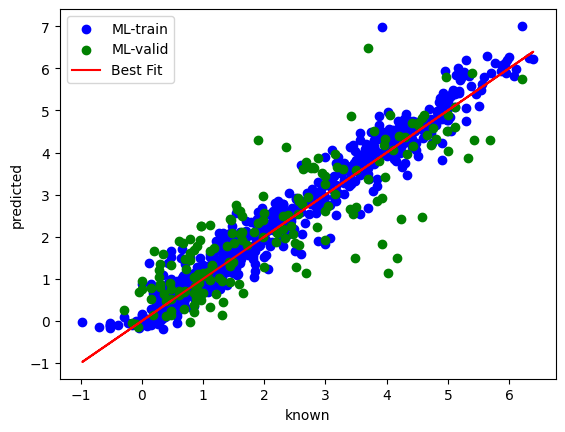

In [92]:
r2_train, r2_test = ccmlp.evaluate_regression(X_train, y_train, X_test, y_test, model)

In [93]:
which = 40
prediction = ccmlp.predict_single_value(smiles[which], model, "rdkit", scaler, truth=y[which])
pred = prediction[0][0].item()
print(f"Prediction: {pred}")
print(f"Truth: {y[which]}")

Predicting value for C[C@@H]1C[C@H](OC(=O)C=C(C)C)C2[C@@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H](C)C=CC2=C1
Prediction: tensor([[1.3065]]), Truth: 1.4313637641589874
Prediction: 1.306541085243225
Truth: 1.4313637641589874


## Save the model

In [94]:
torch.save(model.state_dict(), "saved_model.pt")

## Load a saved model
- needs two files from the previous model:
  * the MLP_model_params.txt file
  * the saved_model.pt file
- Both should be in the current folder [("/content") on Colab]

In [95]:
new_model = ccmlp.load_model()

In [96]:
prediction = ccmlp.predict_single_value(smiles[which], new_model, "rdkit", scaler, truth=y[which])

Predicting value for C[C@@H]1C[C@H](OC(=O)C=C(C)C)C2[C@@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H](C)C=CC2=C1
Prediction: tensor([[1.3065]]), Truth: 1.4313637641589874


## Classifier
- Read in a CSV and create your desired number of classes

In [97]:
class_df, labels = ccmlp.make_classes("/content/905-unique-statins.csv", "IC50 (nM)",3)
class_df.head()

Samples per class: 301, total samples:905


,Unnamed: 0,Ligand SMILES,IC50 (nM),class labels,target
0,7,CC(C)c1c(\C=C\[C@H](O)C[C@@H](O)CC([O-])=O)c(c...,0.106,0.106 < 15.0,0
1,8,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.200,0.106 < 15.0,0
2,10,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c...,0.300,0.106 < 15.0,0
3,11,CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c2C...,0.300,0.106 < 15.0,0
4,12,COC(=O)C[C@H](O)C[C@H](O)\C=C\n1c(C(C)C)c(Br)c...,0.300,0.106 < 15.0,0


In [98]:
class_df.to_csv("class_df.csv", index=False)

- Featurize the data

In [99]:
xc, yc, Xax = ccmlp.featurize(class_df['Ligand SMILES'], class_df['target'], classifier_flag=True)

Old dimensions are: (905, 217).
New dimensions are: (905, 217)


- Scale and split your data, and create Torch dataloaders

In [100]:
stat_class = ccmlp.prep_data(128, classifier_flag=True)
X_train, X_test, y_train, y_test, scaler = stat_class.scale_split(xc, class_df['target'].to_list(), test_size=0.2, random_state=32)

prep data class initialized!


In [101]:
train_dataset, test_dataset, train_loader, test_loader = stat_class.create_data_loader()

- Set-up your Torch MLP model and train

In [102]:
loss_function = nn.NLLLoss()
model = ccmlp.MLP_Model(neurons=400, input_dims=len(X_train[0]), num_hidden_layers=6, classifier_flag=True, num_classes=len(labels))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [103]:
epochs = 60
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  model = ccmlp.train(train_loader, model, loss_function, optimizer, classifier_flag=True, num_classes=len(labels))
print("Done!")

Epoch 1
-------------------------------
Batch: 0, Loss: 1.0993708 [    0/  724]
Batch: 2, Loss: 1.0983456 [  256/  724]
Batch: 4, Loss: 1.0980175 [  512/  724]
Epoch 2
-------------------------------
Batch: 0, Loss: 1.0855819 [    0/  724]
Batch: 2, Loss: 1.0748811 [  256/  724]


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch: 4, Loss: 1.0479970 [  512/  724]
Epoch 3
-------------------------------
Batch: 0, Loss: 0.9175067 [    0/  724]
Batch: 2, Loss: 0.8583894 [  256/  724]
Batch: 4, Loss: 0.8266947 [  512/  724]
Epoch 4
-------------------------------
Batch: 0, Loss: 0.6815588 [    0/  724]
Batch: 2, Loss: 0.7205725 [  256/  724]
Batch: 4, Loss: 0.6872815 [  512/  724]
Epoch 5
-------------------------------
Batch: 0, Loss: 0.5607397 [    0/  724]
Batch: 2, Loss: 0.5328741 [  256/  724]
Batch: 4, Loss: 0.5748183 [  512/  724]
Epoch 6
-------------------------------
Batch: 0, Loss: 0.6254057 [    0/  724]
Batch: 2, Loss: 0.5056961 [  256/  724]
Batch: 4, Loss: 0.5197856 [  512/  724]
Epoch 7
-------------------------------
Batch: 0, Loss: 0.4420337 [    0/  724]
Batch: 2, Loss: 0.4876806 [  256/  724]
Batch: 4, Loss: 0.4973798 [  512/  724]
Epoch 8
-------------------------------
Batch: 0, Loss: 0.4616315 [    0/  724]
Batch: 2, Loss: 0.4929014 [  256/  724]
Batch: 4, Loss: 0.4748685 [  512/  724]


- Evaluate the classifier model

In [104]:
which = 1
targets = class_df['target'].to_list()
prediction = ccmlp.predict_single_value(Xax[which], model, "rdkit", scaler)
pred = np.argmax(prediction)
print(f"Prediction: {pred}")
print(f"Truth: {targets[which]}")

Predicting value for CC(C)n1c(CC[C@@H](O)C[C@@H](O)CC([O-])=O)c(c(c1C(=O)NCc1ccc(cc1)C#N)-c1ccccc1)-c1ccc(F)cc1
Prediction: tensor([[-6.7828e-05, -9.5988e+00, -2.2379e+01]])
Prediction: 0
Truth: 0


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [105]:
stat_eval = ccmlp.evaluate_class(model, labels, test_dataset )

/content/CafChem/CafChemMLPPyTorch.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_tensor = torch.tensor(self.test_values, dtype=torch.float32)


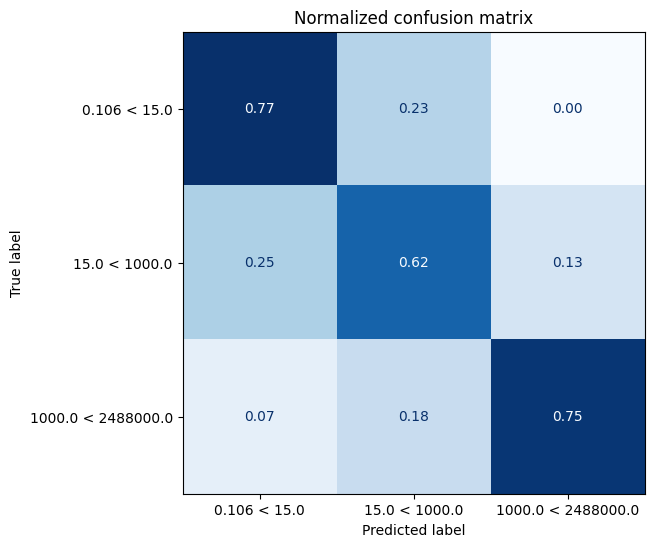

In [106]:
stat_eval.confusion()